# Predicting Time to Destination with NYC Taxi Data

#### Mike Alvarino maa2282 $|$ Colby Wise cjw2165

## Introduction

The NYC Taxi and Limousine Commission (TLC) released a dataset consisting of ~1.2 billion individual yellow and green taxi trips in the city from 2009 onward. For our presentation, we utilized the most recent and complete six month sample of data which at the time of this project was the 2016 data. Additionally, given the size of the dataset we further restricted our dataset to include only yellow cab data within Manhattan.

We can never know the exact algorithm in use by many of popular travel time prediction engines such as Google Maps or Bing Maps. That said, research [1] indicates that many popular engines crowdsource a combination of real-time traffic report data and more recently, user-sourced traffic condition reports (i.e. Waze). From this the estimated trip duration: 

$$\frac{trip\_distance}{est\_speed} + traffic\_time$$

## Problem Formulation

In this project our goal is to approach the trip time estimate problem from the perspective of probabilistic programming and [Box's Loop](https://am207.github.io/2017/wiki/boxloop.html). Specifically, our intent is to use the NYC Taxi and Limousine Commission's yellow cab data to estimate travel time between pickups and dropoffs within Manhattan. The project is build using [Edward](http://edwardlib.org/), a Python library for probabilistic modeling, inference, and criticism.

Throughout our presentation we will be using the example of a traveler visiting New York whose goal is to accurately predict estimated travel time to destinations throughout the day. Our hypothetical traveler wants the most accurate trip time estimates possible.

In [1]:
%matplotlib inline
import edward as ed
from edward.models import Normal
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# our functions
import setup
import data
import visualizations
import basis_functions
import kernels
import critiques
pd.set_option('float_format', '{:f}'.format)
setup.set_random_seeds(42)
plt.style.use("seaborn-talk")
sns.set_context("talk")

/home/michael/Documents/ProbabilisticProgrammingProject/venv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Description of Dataset

The [NYC Yellow Cab Dataset](http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml), consists of pickup and dropoff coordinates for trips, along with metadata like cost, distance, and number of passengers. Columns we expect to find especially useful are those that could affect the time to destination and, obviously, are not known in advance of the trip.Since our dataset was large even after limiting it to only six months and Manhattan, (~1.8 million trips) we segmented the data by neighborhood.

Getting back to our unfamiliar traveler, one example query will want to answer is:

_How much time will it take to get to my friend on the Upper East Side at noon tomorrow coming from Morningside Heights?_

### Key Data Metrics
_Limited to Manhattan_

**Total Samples**: 1,760,396  
**Date Range:** 1/1/2016 - 07/01/2016  
**Borough Mapping:** Longitude/Latitude & 2010 NYC Census Tract Data 

In [2]:
manhattan = data.get_borough_data("data/preprocessed.csv", "Manhattan")
rand_indices = np.random.choice(manhattan.shape[0], size=int(0.1 * manhattan.shape[0]), replace=False)

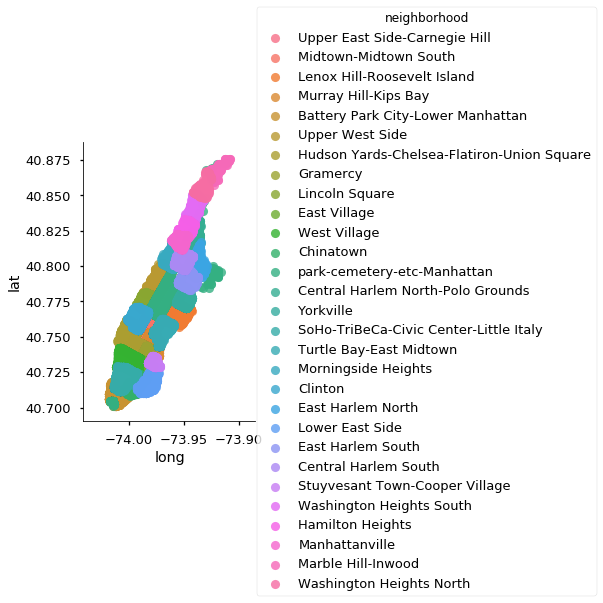

In [3]:
visualizations.visualize_by_borough(manhattan.iloc[rand_indices, :])
plt.show()

#### Training vs Test

Train Size: $\%80$  
Test Size: $\%20$  

#### Limiting Columns
Limit our dataset $X$ to the following columns:   
1. pickup_latitude  
1. pickup_longitude
1. dropoff_latitude
1. dropoff_longitude
1. manhattan_distance
1. pickup_hour
1. pickup_timestamp

Limit $y$ to the following:
1. trip_duration

#### Standardization
Note that we standardize our data such that $x \sim N(0, 1)$

In [4]:
ues_to_msh = data.get_neighborhood_to_neighborhood("Morningside Heights", "Upper East Side-Carnegie Hill", manhattan)
indicator_cols = ["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude", "manhattan_distance", "pickup_hour", "pickup_timestamp"]
y_cols = ["trip_duration"]
x_train_raw, y_train_raw, x_test_raw, y_test_raw = data.train_test_split(ues_to_msh, 0.2, indicator_cols, y_cols)

x_train = data.standardize_cols(x_train_raw)
x_test = data.standardize_cols(x_test_raw)
vis = x_train_raw.copy(deep=True)
vis["trip_duration"] = y_train_raw.copy(deep=True)

# Box's Loop - Iteration 1

## Model: Bayesian GLM

For our first iteration of Box's Loop, we started with a Bayesian General Linear Model, a common baseline for regression models and a good starting point for the Gaussian Process we will be working towards. The model can be framed as the following:


$$f(X) = X^Tw$$
$$y = f(X) + b$$



Where $X$ is the data, $w$ is a vector of weights, $y$ is the prediction, and where
$b \sim N(0, \sigma^2_n)$

We construct the model as follows:

*Normal Prior $w$* = *p(w)* = $N(w\ |\ 0,\ \sigma^2_w I)$

*Normal Prior $b$* = *p($b$)* = $N(b\ |\ 0,\ \sigma^2_b)$

*Likelihood* = *p(y | w,$\epsilon$,X)* = $\prod^N_{n=1} N(y_n\ |\ X^Tw + b)$

*Posterior* = $p(w,\ b|\ y,\ X) \approx p(y\ |\ w,\ b,\ X)\ p(w)\ p(b)$

In [5]:
N, D = x_train.shape
X = tf.placeholder(tf.float32, [N, D])
w = ed.models.Normal(loc=tf.zeros(D), scale=tf.ones(D))
b = ed.models.Normal(loc=[0.0], scale=1.0)

Y = ed.models.Normal(loc=ed.dot(X, w) + b, scale=[1.0])

# Inference

Here we use [Edward's KLqp](http://edwardlib.org/api/ed/KLqp) algorithm to perform inference over the model, allowing our $y$ scale to vary.

In Bayesian statistics the Kullback–Leibler divergence *KL(q||p)* is used as a measure of the information gain in moving from a prior distribution to a posterior distribution. Or more generally, how much information is lost when Q is used to approximate P. When model latent variables are differentiable, Edward will directly minimize the KL(q | p) divergence. If the latent variables are not differentiable, Edward maximizes the ELBO. In our case the priors are conjugate and our latent variables are differentiable.

In [6]:
qw = ed.models.NormalWithSoftplusScale(loc=tf.Variable(tf.random_normal([D])),
                                       scale=tf.Variable(tf.random_normal([D])))

qb = ed.models.NormalWithSoftplusScale(loc=tf.Variable(tf.random_normal([1])),
                                       scale=tf.Variable(tf.random_normal([1])))

inference = ed.KLqp({w: qw, b: qb},
                    data={X: x_train.as_matrix(),
                          Y: y_train_raw.as_matrix().reshape(y_train_raw.shape[0])})
inference.run(n_iter=1000)

1000/1000 [100%] ██████████████████████████████ Elapsed: 1s | Loss: 6446.109


# Criticism

Here given it's just a baseline model we bypass more indepth model criticism and error analysis. Instead, we chose a commonplace and interpretable evaluation metric: *mean absolute error*.  

In [7]:
N, D = x_test.shape
X_eval = tf.placeholder(tf.float32, [N, D])
y_posterior_predictive = ed.models.Normal(loc=ed.dot(X_eval, qw) + qb, scale=[1.0])
print(ed.evaluate("mean_absolute_error",
                  data={X_eval: x_test.as_matrix(),
                        y_posterior_predictive: np.reshape(y_test_raw.as_matrix(), (y_test_raw.shape[0]))},
                  output_key=y_posterior_predictive))

3.49545


Back to our example of a visiting traveller, we can easily see that a 9 to 10 minute average error is poor, so we would like to see what exactly our model has inferred.

By sampling a set of $(w,\ b)$ we can build 

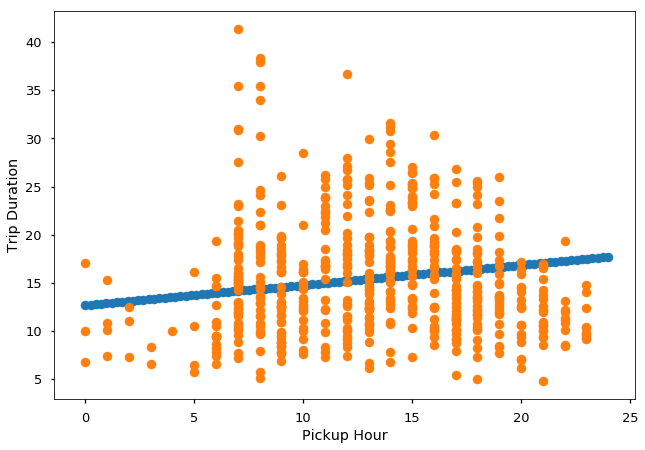

In [8]:
visualizations.vis_glm(100, indicator_cols, vis, qw, qb)

# Box's Loop - Iteration 2

## Model: GLM with Polynomial Basis Function

Moving on in the direction of Gaussian Processes, we would like to begin exploring basis functions. We will begin with a simple polynomial basis function, which is essentially a special case of multiple linear regression. Now we have the following mode:

$$f(\phi(X)) = \phi(X)^Tw$$
$$y = f(\phi(X)) + b$$

Where $\phi$ is the polynomial basis function. 

*We manually explored several polynomial degrees.*

Where $X$ is the data, $w$ is a vector of weights, and $y$ is the prediction.

We construct the model as follows:

*Normal Prior $w$* = *p(w)* = $N(w\ |\ 0,\ \sigma^2_w I)$

*Normal Prior $b$* = *p($b$)* = $N(b\ |\ 0,\ \sigma^2_b)$

*Likelihood* = *p(y | w, $b$, $\phi(X)$)* = $\prod^N_{n=1} N(y_n\ |\ \phi(X)^Tw,\ \sigma^2_n)$

*Posterior* = $p(w,\ b\ |\ y,\ \phi(X)) \approx p(y\ |\ w,\ b,\ \phi(X))\ p(w)\ p(b)$

In [9]:
poly_degree = 4

x_train_2 = basis_functions.polynomial(x_train, degree=poly_degree)
x_test_2 = basis_functions.polynomial(x_test, degree=poly_degree)

In [10]:
N_2, D_2 = x_train_2.shape
X_2 = tf.placeholder(tf.float32, [N_2, D_2])
w_2 = ed.models.Normal(loc=tf.zeros(D_2), scale=tf.ones(D_2))
b_2 = ed.models.Normal(loc=[0.0], scale=1.0)
Y_2 = ed.models.Normal(loc=ed.dot(X_2, w_2) + b_2, scale=[1.0])

# Inference

Again, we will use KLqp inference

In [11]:
qw_2 = ed.models.NormalWithSoftplusScale(loc=tf.Variable(tf.random_normal([D_2])),
                                       scale=tf.Variable(tf.random_normal([D_2])))

qb_2 = ed.models.NormalWithSoftplusScale(loc=tf.Variable(tf.random_normal([1])),
                                       scale=tf.Variable(tf.random_normal([1])))

inference_2 = ed.KLqp({w_2: qw_2, b_2: qb_2},
                    data={X_2: x_train_2.as_matrix(),
                          Y_2: np.reshape(y_train_raw.as_matrix(), (y_train_raw.shape[0]))})
inference_2.run(n_iter=1000)

1000/1000 [100%] ██████████████████████████████ Elapsed: 1s | Loss: 5739.331


# Criticism

The graph below is a showing our training data **orange** vs samples from our predictive distribution **blue**.

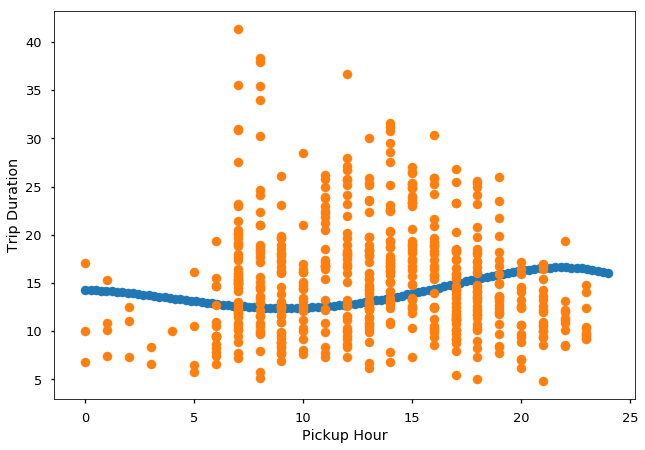

In [12]:
x_vis = pd.DataFrame({i: [0.0] * 100 for i in x_train_2.columns})
visualizations.vis_glm_poly(100, poly_degree, indicator_cols, vis, qw_2, qb_2)


### Mean Absolute Error

The mean absolute error has improved our model. Specifically, our error has shrunk by just under one minute.

**MAE GLM:** ~3.60

**MAE Poly GLM:** ~3.02


In [13]:
N_2, D_2 = x_test_2.shape
X_eval_2 = tf.placeholder(tf.float32, [N_2, D_2])
y_posterior_predictive_2 = ed.models.Normal(loc=ed.dot(X_eval_2, qw_2) + qb_2, scale=[1.0])
print(ed.evaluate("mean_absolute_error",
            data={X_eval_2: x_test_2.as_matrix(),
                  y_posterior_predictive_2: np.reshape(y_test_raw.as_matrix(), (y_test_raw.shape[0]))},
             output_key=y_posterior_predictive_2))

3.25393


### Posterior Predictive Checks

Now, in order to get a better understanding as to the validity of our model, specifically the data generating process we will use posterior predictive checks. Posterior predictive checks allow us to simulate data from our fitted model (posterior) and compare results with the real data. While it does not tell us if our model is "good", discrepancies can tell us if the model makes sense. 

**Mean:** The mean lies in a region of high probabilities density. It does not indicate anything abnormal

**Min:** The minimum lies in a lower region of the sample distribution but not abnormally.

**Max:** The maximum lies far away from the distribution.

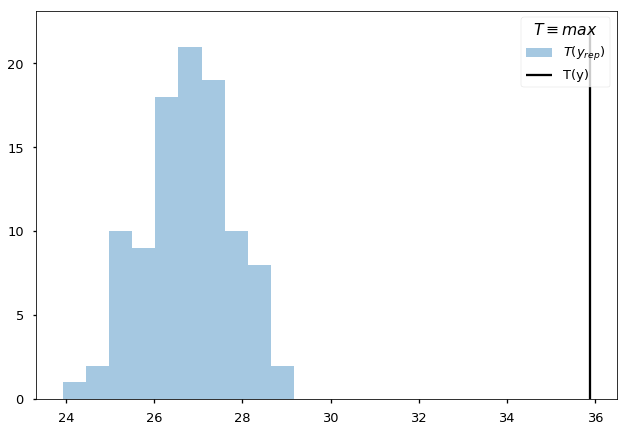

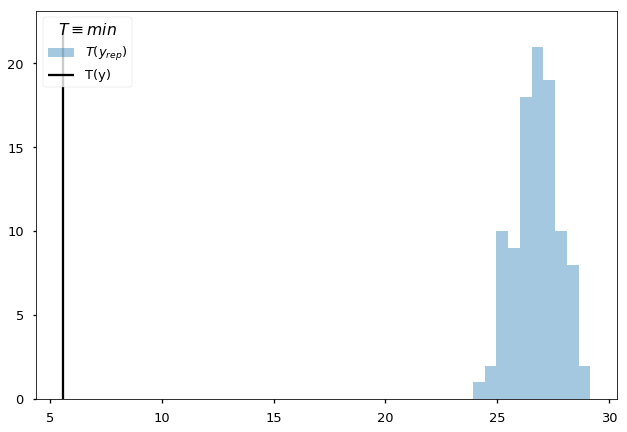

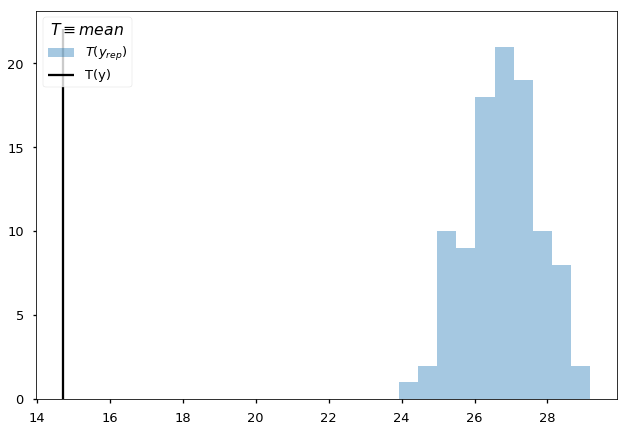

In [14]:
critiques.critique_glm(y_posterior_predictive_2, X_eval_2, x_test_2, y_test_raw,
                       w_2, b_2, qw_2, qb_2)

# Box's Loop - Iteration 3

## Model: Gaussian Process

Gaussian processes (GPs) are a supervised machine learning algorithm that measures the similarity between input data points, using a predefined kernel function, to predict the value of an unseen data point. We like to think about GPs as: defining an infinite distribution on functions over a continuous sapce where we observe some data points and want to assign probabilities to all the ways a line could be drawn through those points. The idea is that we hope these lines (or functions) we draw are similar with high probability to that true function which we will never know. 

Drawing a parallel to our polynomial basis GLM example: instead of choosing a polynomial basis function of degree four, with GPs using a kernel function we'd like to infer the true function from our data. Hence, GPs allow us retain the flexibility of capturing non-linearities in our data but accounting for "infinite" numbers of basis functions. 

### Interpretation of Kernel Function

GPs are parameterized by a pre-determined *kernel function* which is positive-semidefinite covariance function that can capture signals in the data. Through these kernel functions we can explore *smoothness* and *periodicity* in our observed data. At the time of this project, Edward only included [RBF kernel](http://edwardlib.org/api/ed/rbf). We expanded upon this implementation and built a [Rational Quadratic](http://www.cs.toronto.edu/~duvenaud/cookbook/) and Exponential Sine Squared Kernel.

In our analysis we will explore a few kernel functions but note there are many popular kernel functions, some more applicable than others and exploring them all was impossible. 

#### Radial Basis Kernel 
Most people are familiar with RBF given there common use in GPs and SVM in machine learning. The value of the RBF kernel decreases with distance and ranges between zero and one (i.e. x = x'). It's interrupted as a similiarity measure. Where,

*Lengthscale* $l$ =  Determines the length of the 'wiggles' in your function.

*Variance* $\sigma^2$ =  The average distance of your function away from its mean.

$$K_{RB} (x,x') = \sigma^2 \exp \bigg[ \frac{(x-x')^2}{2 l^2}\bigg]  $$


#### Rational Quadratic Kernel
RQ kernels can be viewed as many RBF kernels with different lengthscales. GP priors with this kernel tend to vary smoothly across many lengthscales. 

*Alpha* $\alpha^2$ =  The parameter $\alpha$ determines the relative weighting of large vs small-scale variations.
When $\alpha \to \infty$, RQ == RBF

$$K_{RQ} (x,x') = \sigma^2 \bigg[1 + \frac{(x-x')^2}{2 \alpha l^2} \bigg]^{-\alpha}  $$

#### Exponential Sine Squared Kernel
The ExpSineSquared kernel is typically used when modeling periodic functions or to model functions that repeat themselves. From our data visualizations we thought this may be applicable.

*Lengthscale* $l$ =  Determines the length of the 'wiggles' in your function.

*Periodicity* $p$ = Distnace between repititions of the function

$$K_{ESS} (x,x') = \sigma^2 \exp\bigg[ \frac{- 2 \sin^2(\pi |x-x'|/ p )}{l^2}\bigg]  $$

### Model Overview

A GP can be specified entirely by it's Kernel Function and mean (often assumed to 0): 

Where,

**Prior:** $p(f) = GP(\ 0,\ K(x,x',\theta)\ )$ where $\theta$ = *length_scale* $l_f$, sigma $\sigma_f$

**Likelihood:**  $p(y\ |\ f,\ X,\ \theta) = GP(\ f,\ K(x,x', \theta)\ )$

### Radial Basis Kernel

In [15]:
def gp_reg_invert_K(x, y, x_star, kernel, kernel_params=[]):
    N = tf.cast(x.get_shape()[0], tf.int32).eval(session=tf.Session())
    K = kernel(x, x, *kernel_params)
    k_star = kernel(x_star, x, *kernel_params)
    k_star_star = kernel(x_star, x_star, *kernel_params)
    mu_n, sigma_n_sqr = tf.nn.moments(y, 1)
    K_noisy = K + sigma_n_sqr * tf.eye(N, dtype=tf.float64)
    K_noisy_inv = tf.matrix_inverse(K_noisy)
    f_bar = tf.matmul(tf.matmul(k_star, K_noisy_inv), y)
    tmp = tf.matmul(tf.matmul(k_star, K_noisy_inv), k_star, transpose_b=True)
    v = k_star_star - tmp
    
    k_y = kernel(y, y, *kernel_params)
    y_k_y = tf.matmul(tf.matmul(y, k_y, transpose_a=True), y)
    first = - 0.5 * y_k_y
    second = - 0.5 * tf.log(tf.norm(k_y))
    third = tf.cast(- tf.cast(N, dtype=tf.float32) / 2 * tf.log(2 * np.pi), dtype=tf.float64)
    logp = first + second + third
    
    return f_bar, v, logp

y = tf.constant(y_train_raw.as_matrix())
x = tf.constant(x_train)
x_star = tf.constant(x_test)

f, v, logp = gp_reg_invert_K(x, y, x_star, kernels.rbf, kernel_params=[1.0, 1.0])
mean = np.reshape(f.eval(session=tf.Session()), -1)
covariance = v.eval(session=tf.Session())
sample = np.random.multivariate_normal(mean, covariance)

err = np.abs(sample - y_test_raw.as_matrix())
err.mean()

6.5395090736478787

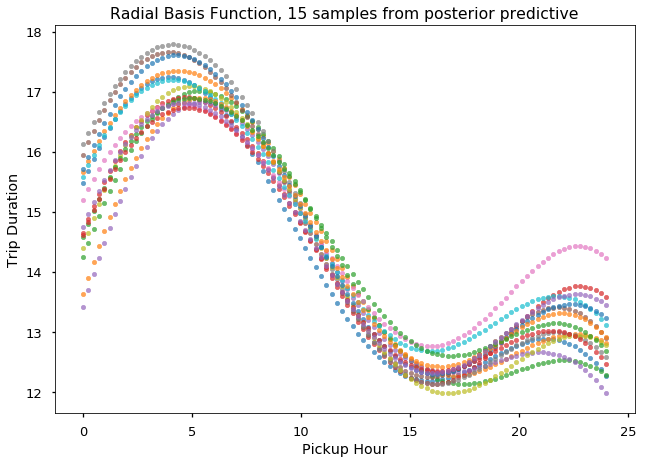

In [16]:
visualizations.vis_gp(x, y, kernels.rbf, indicator_cols, 15, kernel_params=[1.0, 1.0], interp_pnts=100, title="Radial Basis Function, 15 samples from posterior predictive")

### Rational Quadratic Kernel

In [17]:
y = tf.constant(y_train_raw.as_matrix())
x = tf.constant(x_train)
x_star = tf.constant(x_test)

f, v, logp = gp_reg_invert_K(x, y, x_star, kernels.RationalQuadratic, kernel_params=[0.5, 0.1, 1.0])

mean = np.reshape(f.eval(session=tf.Session()), -1)
covariance = v.eval(session=tf.Session())
sample = np.random.multivariate_normal(mean, covariance)

err = np.abs(sample - y_test_raw.as_matrix())
err.mean()

5.4390622067101937

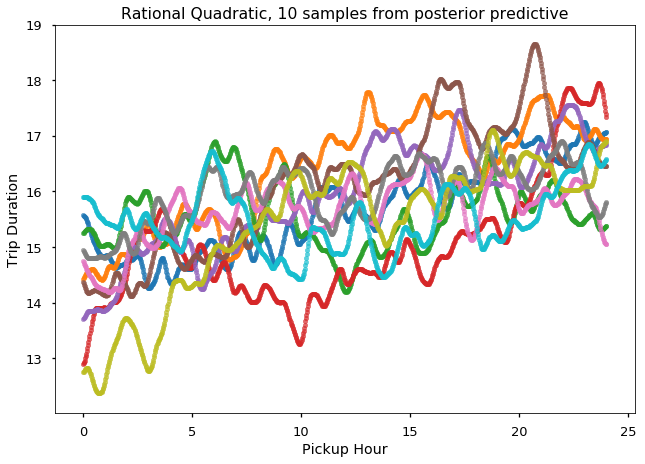

In [18]:
title = "Rational Quadratic, 10 samples from posterior predictive"
visualizations.vis_gp(x, y, kernels.RationalQuadratic, indicator_cols, 10, kernel_params=[0.5, 0.1, 1.0], interp_pnts=1000, title=title)

### Exponential Sine Squared Kernel

In [19]:
y = tf.constant(y_train_raw.as_matrix())
x = tf.constant(x_train)
x_star = tf.constant(x_test)

f, v, logp = gp_reg_invert_K(x, y, x_star, kernels.ExpSineSquared, kernel_params=[0.5, 9.0, 3.0])

mean = np.reshape(f.eval(session=tf.Session()), -1)
covariance = v.eval(session=tf.Session())
sample = np.random.multivariate_normal(mean, covariance)

err = np.abs(sample - y_test_raw.as_matrix())
err.mean()

6.2923638121788716

# Future Work


There are a number of things we’d like to try in the future based on our experiences during the project. Firstly, while GPs are powerful tools to infer functions from one’s data, choosing the kernel function remains a challenging task.  The “periodic” family kernels like RBF and exponential sine squared are the common tools of the trade, however there are numerous other kernels that may be applicable to one’s dataset.  More to point, we would want to explore combinations of kernels such as RBF plus White-Noise kernel which research has empirically shown can lead to better results. Thus, for future work we’d definitely like to implement and explore additional kernel functions given Edward currently only has one kernel function. 

Secondly, setting kernel hyperparameters is very painful and wrought in uncertainty. In our project we performed a naïve manual search for the best hyperparameters and over time iteratively built our intuition for how length-scale, variance, and other kernel parameters impacted our model fit. One way to do this would be to perform MLE or MAP estimation on kernel hyperparameters. Alternately, there are MC approaches that have been shown to be slow, unfortunately we did not have time to implement these. In addition to implementing a broader suite of kernels in Edward, we would further add features that let users optimize kernel hyperparameters during the model fitting process. Note, that this is possible in other GP dedicated packages such as scikit-learn, George, and PyMC3. 

Lastly, while we made progress implementing GPs with Edward we struggled implementing model criticisms. Specifically, with our custom kernel function implementations we could not get Edward’s posterior predictive check functionality working despite numerous efforts. Eventually we resorted to a numpy only implementation for our GP and sampled from this posterior.